In [ ]:
!pip install bilby lalsuite

In [8]:
import lalsimulation as lalsim
import lal
import bilby
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

solar_mass = bilby.core.utils.constants.solar_mass
parsec = bilby.core.utils.constants.parsec

# Generating time domain waveforms and projecting them onto the detectors

In this notebook, I'll demonstrate how to use `lalsimulation` to generate a time-domain waveform and how to then use `bilby` to calculate the response of an interferometer.

## Setting a few things up

To get started, let's define some properties of the data we want to simulate. This is the sampling frequency, duration and the amount of time before and after the trigger time (roughly speaking, the peak of the 2,2 mode).


In [9]:
sampling_frequency = 4096
deltaT = 1 / sampling_frequency
duration = 4
post_trigger_duration = 0.5
pre_trigger_duration = duration - post_trigger_duration

## Generate a waveform

Now, we'll use `lalsim.SimInspiralChooseTDWaveform` to generate the plus and cross polarization

In [10]:
# Define the parameters in SI units
mass_1 = 30 * solar_mass
mass_2 = 30 * solar_mass
spin_1x, spin_1y, spin_1z = 0, 0, 0
spin_2x, spin_2y, spin_2z = 0, 0, 0
luminosity_distance = 2000
theta_jn = 0
phase = 0

longAscNodes = 0
eccentricity = 0
meanPerAno = 0
LALParams = lal.CreateDict()

# Get the approximant number from the name
waveform_approximant = "IMRPhenomT"
approximant = lalsim.GetApproximantFromString(waveform_approximant)

# Estimate a minimum frequency required to ensure the waveform covers the data
# Note the 0.95 is a fudge factor as SimInspiralChirpStartFrequencyBound includes
# only the leading order Newtonian coefficient.
f_min = 0.95 * lalsim.SimInspiralChirpStartFrequencyBound(pre_trigger_duration, mass_1, mass_2)
if lalsim.SimInspiralGetSpinFreqFromApproximant(approximant) == lalsim.SIM_INSPIRAL_SPINS_FLOW:
    f_ref = f_min
else:
    f_ref = 20

h_plus_timeseries, h_cross_timeseries = lalsim.SimInspiralChooseTDWaveform(
    mass_1, mass_2, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z, luminosity_distance, theta_jn, phase, 
    longAscNodes, eccentricity, meanPerAno, deltaT, f_min, f_ref, LALParams,
    approximant
)

## Extract the data

In [11]:
h_plus = h_plus_timeseries.data.data
h_cross = h_cross_timeseries.data.data
h_plus_time = np.arange(len(h_plus)) * h_plus_timeseries.deltaT + float(h_plus_timeseries.epoch)
h_cross_time = np.arange(len(h_cross)) * h_cross_timeseries.deltaT + float(h_cross_timeseries.epoch)

## Project onto the Hanford interferometer

In [12]:
ra = 1.2
dec = -3.1
geocent_time = 1126259462.1
psi = 0.5
H1 = bilby.gw.detector.get_empty_interferometer("H1")

plus_polarization_tensor = bilby.gw.utils.get_polarization_tensor(ra, dec, geocent_time, psi, "plus")
f_plus = np.einsum('ij,ij->', H1.detector_tensor, plus_polarization_tensor)

cross_polarization_tensor = bilby.gw.utils.get_polarization_tensor(ra, dec, geocent_time, psi, "cross")
f_cross = np.einsum('ij,ij->', H1.detector_tensor, cross_polarization_tensor)

strain = f_plus * h_plus + f_cross * h_cross
strain_time = h_plus_time

## Plot the data

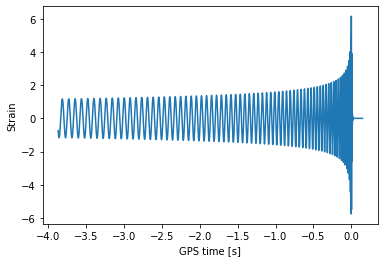

In [13]:
plt.plot(strain_time, strain)
plt.ylabel("Strain")
plt.xlabel(f"GPS time [s]")
plt.show()

From the plot above (or by inspecting `strain` and `strain_time`), we see that `SimInspiralChooseTDWaveform` outputs the strain on a grid of times with sampling frequency `1/deltaT`, but that the duration is determined by `f_min` and that peak of the 2,2 mode occurs at `0`.

We can translate this to the time measured by a detector by simply adding `geocent_time`, and the detector time delay from the geocenter, e.g.

In [14]:
time_shift = H1.time_delay_from_geocenter(ra, dec, geocent_time)
strain_detector_time = strain_time + geocent_time + time_shift

But, we'll want to compare our predicted strain with a timeseries of detector data which will be sampled on a different grid (even if the sampling frequency is identical, we would not expect a sampled timeseries to align with the peak of the 2,2 mode!). To convert, we can interpolate.

## Interpolate onto a sampled data grid


In [15]:
n = sampling_frequency * duration
data_start_time = int(geocent_time) - pre_trigger_duration
data_detector_time = np.arange(n) / sampling_frequency + data_start_time 
h_interp = interp1d(strain_detector_time, strain, fill_value=0, bounds_error=False)(data_detector_time)

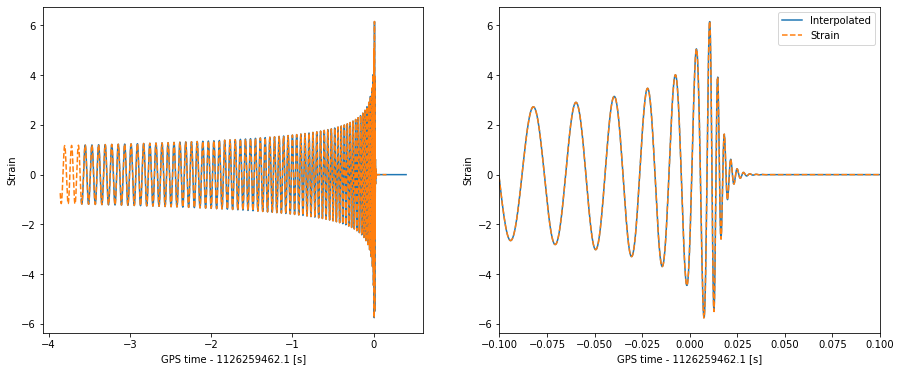

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
ax1.plot(data_detector_time - geocent_time, h_interp)
ax1.plot(strain_detector_time - geocent_time, strain, "--")
ax1.set_ylabel("Strain")
ax1.set_xlabel(f"GPS time - {geocent_time} [s]")
ax2.plot(data_detector_time - geocent_time, h_interp, label="Interpolated")
ax2.plot(strain_detector_time - geocent_time, strain, "--", label="Strain")
ax2.set_ylabel("Strain")
ax2.set_xlabel(f"GPS time - {geocent_time} [s]")
ax2.set_xlim(-0.1, 0.1)
ax2.legend()
plt.show()

## Putting it all together into a single function

In [17]:
from bilby.gw.utils import _get_lalsim_approximant, convert_args_list_to_float

def get_gw_waveform(time, parameters, waveform_approximant, reference_frequency, bilby_detector, fudge=0.85, reference_frame=None, pre_trigger_duration=None, error=False):
    par, _ = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters(parameters)
        
    mass_1_SI = par["mass_1"] * solar_mass
    mass_2_SI = par["mass_2"] * solar_mass
    luminosity_distance_SI = par["luminosity_distance"] * 1e6 * parsec
    
    # Extract information about the time series
    deltaT = time[1] - time[0]
    if pre_trigger_duration is None:
        nearest_trigger_idx = np.argmin(np.abs(time - par["geocent_time"]))
        pre_trigger_duration = time[nearest_trigger_idx] - time[0]
    
    # Get the approximant number from the name
    approximant = _get_lalsim_approximant(waveform_approximant)

    # Estimate a minimum frequency required to ensure the waveform covers the data
    # Note the 0.95 is a fudge factor as SimInspiralChirpStartFrequencyBound includes
    # only the leading order Newtonian coefficient.
    f_min = fudge * lalsim.SimInspiralChirpStartFrequencyBound(
        pre_trigger_duration, 
        mass_1_SI,
        mass_2_SI,
    )
    
    # Check if the reference frequency is used, if not use f_min
    if lalsim.SimInspiralGetSpinFreqFromApproximant(approximant) == lalsim.SIM_INSPIRAL_SPINS_FLOW:
        f_ref = f_min
    elif reference_frequency == "fmin":
        f_ref = f_min
    else:
        f_ref = reference_frequency
        
    iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = bilby.gw.conversion.bilby_to_lalsimulation_spins(
        theta_jn=par["theta_jn"], phi_jl=par["phi_jl"], tilt_1=par["tilt_1"], tilt_2=par["tilt_2"],
        phi_12=par["phi_12"], a_1=par["a_1"], a_2=par["a_2"], mass_1=mass_1_SI, mass_2=mass_2_SI,
        reference_frequency=f_ref, phase=par["phase"])

    if "zenith" in par and "azimuth" in par:
        par["ra"], par["dec"] = bilby.gw.utils.zenith_azimuth_to_ra_dec(
            par['zenith'], par['azimuth'], par["geocent_time"], reference_frame)

    longitude_ascending_nodes = 0.
    eccentricity = 0.
    mean_per_ano = 0.
    waveform_dictionary = lal.CreateDict()
    
    args = convert_args_list_to_float(
        mass_1_SI, mass_2_SI,
        spin_1x, spin_1y, spin_1z,
        spin_2x, spin_2y, spin_2z,
        luminosity_distance_SI, iota, par["phase"],
        longitude_ascending_nodes, eccentricity, mean_per_ano,
        deltaT, f_min, f_ref)

    h_plus_timeseries, h_cross_timeseries = lalsim.SimInspiralChooseTDWaveform(
        *args, waveform_dictionary, approximant   
    )

    plus_polarization_tensor = bilby.gw.utils.get_polarization_tensor(par["ra"], par["dec"], par["geocent_time"], par["psi"], "plus")
    f_plus = np.einsum('ij,ij->', bilby_detector.detector_tensor, plus_polarization_tensor)

    cross_polarization_tensor = bilby.gw.utils.get_polarization_tensor(par["ra"], par["dec"], par["geocent_time"], par["psi"], "cross")
    f_cross = np.einsum('ij,ij->', bilby_detector.detector_tensor, cross_polarization_tensor)

    h_plus = h_plus_timeseries.data.data
    h_cross = h_cross_timeseries.data.data
    h_plus_time = np.arange(len(h_plus)) * h_plus_timeseries.deltaT + float(h_plus_timeseries.epoch)

    h = f_plus * h_plus + f_cross * h_cross
    t = h_plus_time + par["geocent_time"] + bilby_detector.time_delay_from_geocenter(par["ra"], par["dec"], par["geocent_time"])

    h_interp = interp1d(t, h, fill_value=0, bounds_error=False)(time)
    
    if h_interp[0] == 0:
        msg = "Generated waveform was too short"
        if error:
            raise ValueError(msg)
        else:
            print(msg)

    return h_interp



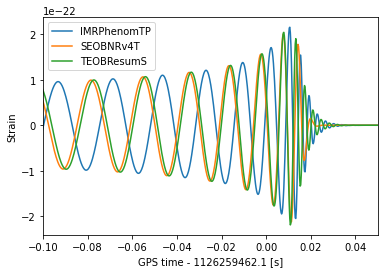

In [18]:
parameters = dict(
    mass_1=36., mass_2=29., chi_1=0., chi_2=0., luminosity_distance=2000., theta_jn=0.4, psi=2.659,
    phase=2.8, geocent_time=geocent_time, ra=1.375, dec=-1.2108
)

for waveform in ["IMRPhenomTP", "SEOBNRv4T", "TEOBResumS"]:
    w = get_gw_waveform(data_detector_time, parameters, waveform, "fmin", H1, fudge=0.85)
    plt.plot(data_detector_time - geocent_time, w, label=waveform)
    
plt.xlim(-0.1, 0.05)
plt.ylabel("Strain")
plt.xlabel(f"GPS time - {geocent_time} [s]")
plt.legend()
plt.show()

## Time the generation

In [14]:
prior = bilby.gw.prior.BBHPriorDict()
prior["geocent_time"] = bilby.core.prior.Uniform(geocent_time - 0.1, geocent_time + 0.1)

09:48 bilby INFO    : No prior given, using default BBH priors in /home/greg/bilby/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [15]:
%%timeit
_ = get_gw_waveform(data_detector_time, prior.sample(), "SEOBNRv4P", 20, H1, fudge=0.85)


1.56 s ± 297 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit
_ = get_gw_waveform(data_detector_time, prior.sample(), "IMRPhenomTP", 20, H1, fudge=0.85)

33.2 ms ± 7.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%%timeit
_ = get_gw_waveform(data_detector_time, prior.sample(), "IMRPhenomPv2", 20, H1, fudge=1)

12 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Profile the generation

In [18]:
%load_ext line_profiler

In [19]:
%lprun -T profile.txt -s -u 1e-3 -f get_gw_waveform get_gw_waveform(data_detector_time, prior.sample(), "IMRPhenomTP", 20, H1, fudge=0.85)


*** Profile printout saved to text file 'profile.txt'. 


In [20]:
!head -n 15 profile.txt

Timer unit: 0.001 s

Total time: 0.033181 s
File: /tmp/ipykernel_18938/2443159286.py
Function: get_gw_waveform at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def get_gw_waveform(time, parameters, waveform_approximant, reference_frequency, bilby_detector, fudge=0.85, reference_frame=None, pre_trigger_duration=None, error=False):
     4         1          0.1      0.1      0.2      par, _ = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters(parameters)
     5                                                   
     6         1          0.0      0.0      0.0      mass_1_SI = par["mass_1"] * solar_mass
     7         1          0.0      0.0      0.0      mass_2_SI = par["mass_2"] * solar_mass
     8         1          0.0      0.0      0.0      luminosity_distance_SI = par["luminosity_distance"] * 1e6 * parsec
     9                                               


In [21]:
!tail -n +9 profile.txt | sort -nr -k 3 | head -n 10

    58         4         30.8      7.7     92.7      h_plus_timeseries, h_cross_timeseries = lalsim.SimInspiralChooseTDWaveform(
    13         1          0.7      0.7      2.1          nearest_trigger_idx = np.argmin(np.abs(time - par["geocent_time"]))
    75         1          0.6      0.6      1.8      h_interp = interp1d(t, h, fill_value=0, bounds_error=False)(time)
    72         1          0.3      0.3      0.9      h = f_plus * h_plus + f_cross * h_cross
    62         1          0.2      0.2      0.7      plus_polarization_tensor = bilby.gw.utils.get_polarization_tensor(par["ra"], par["dec"], par["geocent_time"], par["psi"], "plus")
    36         2          0.2      0.1      0.6      iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = bilby.gw.conversion.bilby_to_lalsimulation_spins(
    73         1          0.1      0.1      0.4      t = h_plus_time + par["geocent_time"] + bilby_detector.time_delay_from_geocenter(par["ra"], par["dec"], par["geocent_time"])
    70   

We can remove that lookup for the `pre_trigger_duration` if we know it

In [22]:
%lprun -T profile.txt -s -u 1e-3 -f get_gw_waveform get_gw_waveform(data_detector_time, prior.sample(), "IMRPhenomTP", 20, H1, fudge=0.85, pre_trigger_duration=pre_trigger_duration)
!tail -n +9 profile.txt | sort -nr -k 3 | head -n 10


*** Profile printout saved to text file 'profile.txt'. 
    58         4         38.2      9.5     91.9      h_plus_timeseries, h_cross_timeseries = lalsim.SimInspiralChooseTDWaveform(
    70         1          1.1      1.1      2.8      h_plus_time = np.arange(len(h_plus)) * h_plus_timeseries.deltaT + float(h_plus_timeseries.epoch)
    75         1          1.0      1.0      2.4      h_interp = interp1d(t, h, fill_value=0, bounds_error=False)(time)
    36         2          0.3      0.2      0.8      iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = bilby.gw.conversion.bilby_to_lalsimulation_spins(
    73         1          0.2      0.2      0.5      t = h_plus_time + par["geocent_time"] + bilby_detector.time_delay_from_geocenter(par["ra"], par["dec"], par["geocent_time"])
    72         1          0.2      0.2      0.4      h = f_plus * h_plus + f_cross * h_cross
    62         1          0.2      0.2      0.6      plus_polarization_tensor = bilby.gw.utils.get_polarizatio

In [20]:
nospin_prior = bilby.gw.prior.BBHPriorDict()
for key in bilby.gw.source.spin:
    if key in nospin_prior:
        nospin_prior[key] = 0
        
nospin_prior["geocent_time"] = bilby.core.prior.Uniform(geocent_time - 0.1, geocent_time + 0.1)


09:54 bilby INFO    : No prior given, using default BBH priors in /home/greg/bilby/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [21]:
%%timeit
_ = get_gw_waveform(data_detector_time, nospin_prior.sample(), "IMRPhenomT", 20, H1, fudge=0.85)

7.82 ms ± 523 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%%timeit
_ = get_gw_waveform(data_detector_time, nospin_prior.sample(), "IMRPhenomXAS", 20, H1, fudge=0.85)

13.1 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
